## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\gg\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[128,64,32]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [44]:
# 載入 Callbacks
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import numpy as np

# Record_fp_tp
class Record_tp_tn(Callback):
    """Define a callback function to collect tp/tn, named Record_fp_tp.
    
    """
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        print(y_true)
        print(y_pred)
        print(confusion_matrix(y_true,y_pred))
        print(precision_score(y_true, y_pred, average=None))
        
        conf_matrix = confusion_matrix(y_true,y_pred)
        
        FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
        FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
        TP = np.diag(conf_matrix)
        TN = conf_matrix.sum() - (FP + FN + TP)
        
        
        logs["val_tp"] = TP
        logs["val_tn"] = TN
        
        
rec_tptn = Record_tp_tn()

In [45]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""
To do:
Fit the model with rec_tptn callback_fn
"""
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_tptn]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

"""
To do:
Collect tp/tn from model history
"""
valid_tp = model.history.history["val_tp"]
valid_tn = model.history.history["val_tn"]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
batch_normalization_34 (Batc (None, 128)               512       
_________________________________________________________________
hidden_layer2 (Dense)        (None, 64)                8256      
_________________________________________________________________
batch_normalization_35 (Batc (None, 64)                256       
_________________________________________________________________
hidden_layer3 (Dense)        (None, 32)                2080      
_________________________________________________________________
batch_normalization_36 (Batc (None, 32)                128       
__________

C:\Users\gg\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


50000/50000 [==============================] - 4s 87us/step - loss: 1.8953 - acc: 0.3281 - val_loss: 1.9739 - val_acc: 0.3077
[3 8 8 ... 5 1 7]
[0 0 0 ... 0 0 0]
[[998   2   0   0   0   0   0   0   0   0]
 [908  92   0   0   0   0   0   0   0   0]
 [996   4   0   0   0   0   0   0   0   0]
 [996   4   0   0   0   0   0   0   0   0]
 [998   2   0   0   0   0   0   0   0   0]
 [998   2   0   0   0   0   0   0   0   0]
 [996   4   0   0   0   0   0   0   0   0]
 [995   5   0   0   0   0   0   0   0   0]
 [989  11   0   0   0   0   0   0   0   0]
 [977  23   0   0   0   0   0   0   0   0]]
[0.10130951 0.61744966 0.         0.         0.         0.
 0.         0.         0.         0.        ]
Epoch 3/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.7933 - acc: 0.3661 - val_loss: 1.8390 - val_acc: 0.3424
[3 8 8 ... 5 1 7]
[0 0 0 ... 0 0 0]
[[ 998    2    0    0    0    0    0    0    0    0]
 [ 875  125    0    0    0    0    0    0    0    0]
 [ 997    3    0    0  

50000/50000 [==============================] - 5s 91us/step - loss: 1.4698 - acc: 0.4830 - val_loss: 1.5787 - val_acc: 0.4410
[3 8 8 ... 5 1 7]
[0 0 0 ... 0 0 0]
[[993   7   0   0   0   0   0   0   0   0]
 [715 285   0   0   0   0   0   0   0   0]
 [996   4   0   0   0   0   0   0   0   0]
 [998   2   0   0   0   0   0   0   0   0]
 [999   1   0   0   0   0   0   0   0   0]
 [999   1   0   0   0   0   0   0   0   0]
 [996   4   0   0   0   0   0   0   0   0]
 [999   1   0   0   0   0   0   0   0   0]
 [984  16   0   0   0   0   0   0   0   0]
 [942  58   0   0   0   0   0   0   0   0]]
[0.10321172 0.75197889 0.         0.         0.         0.
 0.         0.         0.         0.        ]
Epoch 15/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.4526 - acc: 0.4879 - val_loss: 1.5579 - val_acc: 0.4500
[3 8 8 ... 5 1 7]
[0 0 0 ... 0 0 0]
[[987  13   0   0   0   0   0   0   0   0]
 [596 404   0   0   0   0   0   0   0   0]
 [995   5   0   0   0   0   0   0   0   0]

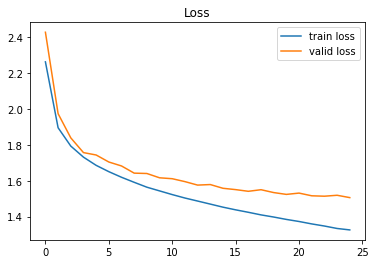

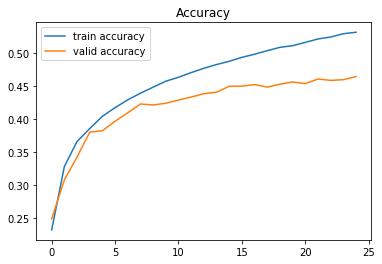

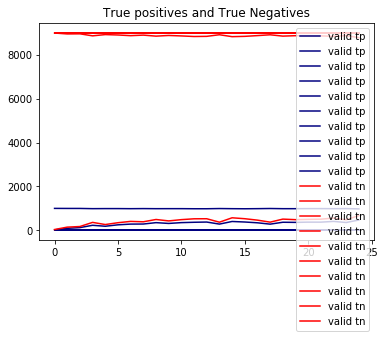

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()
